In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
pip install tensorflow pandas matplotlib gradio


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist

def generate_unlabeled_csv(filename='unlabeled_digits.csv', num_samples=100):
    (_, _), (X_test, _) = mnist.load_data()
    X_test = X_test.reshape(-1, 784).astype('float32')
    np.random.shuffle(X_test)
    sample = X_test[:num_samples]
    df = pd.DataFrame(sample)
    df.to_csv(filename, index=False, header=False)
    print(f"Saved {num_samples} unlabeled images to '{filename}'.")

if __name__ == "__main__":
    generate_unlabeled_csv()




11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saved 100 unlabeled images to 'unlabeled_digits.csv'.


Training new model on MNIST...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.8083 - loss: 0.6011
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.9717 - loss: 0.0942
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.9799 - loss: 0.0658
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.9850 - loss: 0.0517
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.9866 - loss: 0.0444



Loading unlabeled data from unlabeled_digits.csv...


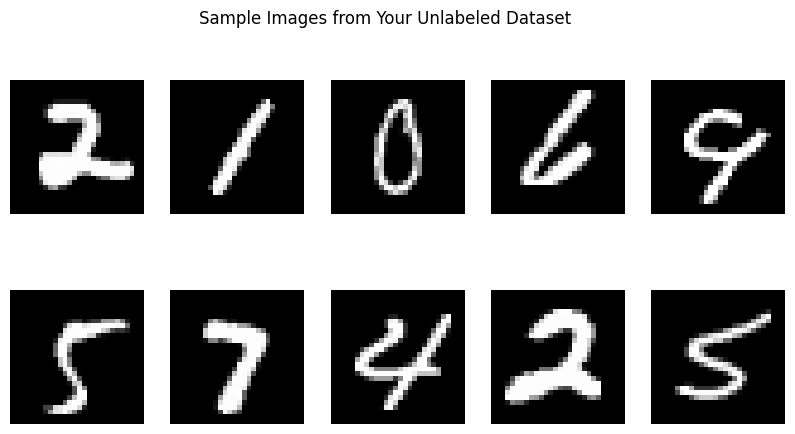


Launching Gradio demo...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bb9526d5aff85cabb5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Handwritten Digit Recognition with Unlabeled Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import gradio as gr
import os

def load_unlabeled_data(file_path):
    """Load image data from CSV without labels"""
    df = pd.read_csv(file_path, header=None)
    images = df.values.astype('float32')
    return images

def preprocess_images(images):
    """Preprocess unlabeled images"""
    images = images / 255.0
    if images.shape[1] == 784:
        images = images.reshape(-1, 28, 28, 1)
    return images

def build_model():
    """Build CNN model for digit recognition"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def predict_digit(model):
    """Create prediction function for Gradio"""
    def predict(img):
        img = img.reshape(1, 28, 28, 1) / 255.0
        prediction = model.predict(img)[0]
        return {str(i): float(prediction[i]) for i in range(10)}
    return predict

def main():
    # Load or train model
    model_file = 'digit_recognition_model.h5'
    if os.path.exists(model_file):
        print("Loading pretrained model...")
        model = tf.keras.models.load_model(model_file)
    else:
        print("Training new model on MNIST...")
        (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
        X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
        y_train = to_categorical(y_train, 10)
        model = build_model()
        model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
        model.save(model_file)

    # Load unlabeled dataset
    dataset_path = 'unlabeled_digits.csv'
    if os.path.exists(dataset_path):
        print(f"\nLoading unlabeled data from {dataset_path}...")
        unlabeled_data = load_unlabeled_data(dataset_path)
        processed_images = preprocess_images(unlabeled_data)

        # Show sample images
        plt.figure(figsize=(10, 5))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(processed_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle("Sample Images from Your Unlabeled Dataset")
        plt.show()
    else:
        print(f"\nNo unlabeled dataset found at {dataset_path}")

    # Gradio UI
    print("\nLaunching Gradio demo...")
    interface = gr.Interface(
        fn=predict_digit(model),
        inputs="sketchpad",
        outputs=gr.Label(num_top_classes=3),
        live=True,
        title="Handwritten Digit Recognition",
        description="Draw a digit (0-9) to see the prediction"
    )
    interface.launch()

# Run script
if __name__ == "__main__":
    main()

